# Analyzing HIV Drug Resistance

We consider the dataset data set publicly available from the Stanford HIV Drug Resistance Database (https://hivdb.stanford.edu/pages/published_analysis/genophenoPNAS2006/)

In [1]:
import pandas as pd
import numpy as np

In [113]:
X = pd.read_csv("X.csv", index_col=0)
column_names = X.columns
X.head()

,P4.A,P12.A,P13.A,P16.A,P20.A,P22.A,P28.A,P37.A,P51.A,P54.A,...,P16.Z,P18.Z,P19.Z,P34.Z,P37.Z,P61.Z,P72.Z,P79.Z,P83.Z,P92.Z
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
Y = pd.read_csv("Y.csv", index_col=0)
Y.head()

,APV,ATV,IDV,LPV,NFV,RTV,SQV
1,2.3,NaN,32.7,NaN,23.4,51.6,37.8
2,76.0,NaN,131.0,200.0,50.0,200.0,156.0
3,2.8,NaN,12.0,NaN,100.0,41.0,145.6
4,6.5,9.2,2.1,5.3,5.0,36.0,13.0
5,8.3,NaN,100.0,NaN,161.1,170.2,100.0


In [4]:
Y.isna().sum(axis=0)

APV     79
ATV    518
IDV     21
LPV    331
NFV      4
RTV     53
SQV     22
dtype: int64

# Exercise 1

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

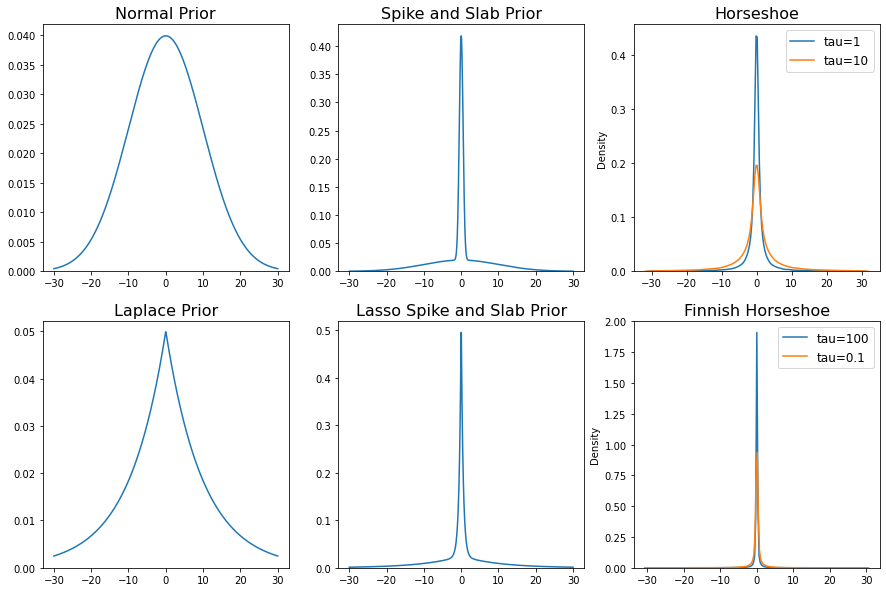

In [103]:
xgrid = np.linspace(-30, 30, 1000)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

axes[0][0].plot(xgrid, ??)
axes[0][0].set_title("Normal Prior", fontsize=16)

axes[1][0].plot(xgrid, ??)
axes[1][0].set_title("Laplace Prior", fontsize=16)

axes[0][1].plot(xgrid, ??)
axes[0][1].set_title("Spike and Slab Prior", fontsize=16)

axes[1][1].plot(xgrid, ??)
axes[1][1].set_title("Lasso Spike and Slab Prior", fontsize=16)


sns.kdeplot(??, ax=axes[0][2], label="tau=1")
sns.kdeplot(??, ax=axes[0][2], label="tau=10")
axes[0][2].legend(fontsize=12)
axes[0][2].set_title("Horseshoe", fontsize=16)

sns.kdeplot(??, ax=axes[1][2], label="tau=100")
sns.kdeplot(??, ax=axes[1][2], label="tau=0.1")
axes[1][2].legend(fontsize=12)
axes[1][2].set_title("Finnish Horseshoe", fontsize=16)


for i in range(2):
    for j in range(3):
        axes[i, j].set_ylim(0)
        
        
plt.savefig("priors.pdf", bbox_inches="tight")
    
plt.show()

## Unit balls plot


Normal prior: $- \log \pi(\beta) = \|\beta\|_2^2 / \tau$

DE prior:  $- \log \pi(\beta) = \|\beta\|_1 / \tau$


Horseshoe prior: $- \log \pi(\beta1, \beta_2) \approx \log \log \left(1 + \frac{2 \tau^2}{\beta_1^2} \right) +  \log \log \left(1 + \frac{2 \tau^2}{\beta_2^2} \right)$

In [8]:
from scipy.optimize import fsolve


def neg_log_hors(beta1, beta2, r, tau):
    return np.log(np.log(1 + 2 * tau**2 / beta1**2)) + \
        np.log(np.log(1 + 2 * tau**2 / beta2**2))

def get_hors_levelset(beta1, r=1, tau=1):
    # TODO

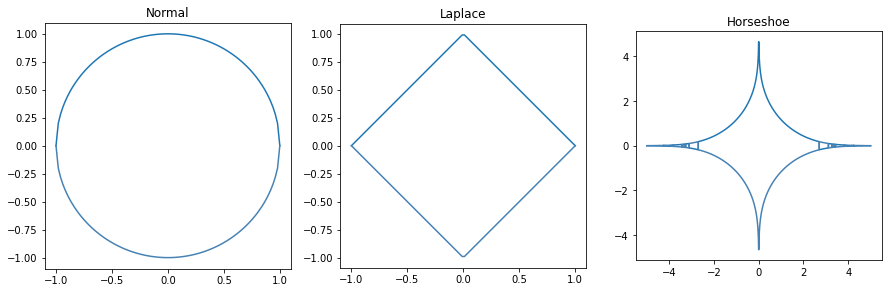

In [102]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

r = 1
tau = 1

x = np.linspace(-1, 1, 100)
axes[0].set_title("Normal")

axes[1].set_title("Laplace")

x = np.linspace(-5, 5, 1000)
axes[2].set_title("Horseshoe")

for i in range(3):
    axes[i].set_aspect('equal', 'box')

plt.savefig("images/balls.pdf", bbox_inches="tight")
    
plt.show()

# Exercise 2 

In [10]:
from cmdstanpy import CmdStanModel, set_cmdstan_path
import arviz as az

#### Hint 1

To implement the spike-and-slab priors in Stan, you need to marginalize out the latent parameter $p_j$ and write
$$
    \beta_j \sim \pi(\beta_j)
$$
$\pi(\beta_j)$ will be a mixture of two densities, say $\pi(\beta_j) = w \pi_1(\beta_j + (1-w) \pi_2(\beta_j)$.

In stan, you cannot write


   beta_j $\sim  w \pi_1(\beta_j + (1-w) \pi_2(\beta_j)$


But what you can do instead is writing

<pre>
target_lpdf += log_mix(w,
        p1_lpdf(beta | params1),
        p2_lpdf(beta | params2));
</pre>    
        
Where p1_lpdf is the log-probability density function associated to $\pi_1$, i.e. if $\pi_1 = \mathcal{N}(0, 10^2)$ and $\pi_2 = \mathcal{N}(0, 0.1^2)$ we write

<pre>
target_lpdf += log_mix(w, 
       normal_lpdf(beta | 0, 10),
       normal_lpdf(beta | 0, 0.1));
</pre>


#### Hint 2

If you get way too many divergent transistions, it might be due to the heavy tails of the Cauchy distribution.
A practical way to get rid of them is to assume instead an half-T prior (i.e., a student's T distribution truncated on $[0, +\infty)$ with small degrees of freedom parameters.

### Select data and discard missing values

In [11]:
Y.columns

Index(['APV', 'ATV', 'IDV', 'LPV', 'NFV', 'RTV', 'SQV'], dtype='object')

In [12]:
y = Y["APV"].values
keep = np.where(~np.isnan(y))
y = y[keep]
X = X.values[keep, :][0, :, :]

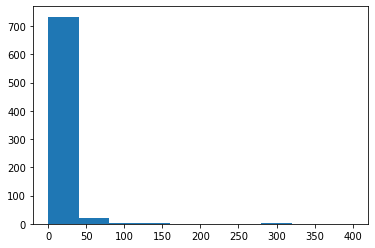

In [29]:
plt.hist(y)
plt.show()

(array([ 36., 103., 211., 104., 132.,  89.,  48.,  31.,   8.,   5.]),
 array([-2.30258509, -1.47318013, -0.64377516,  0.1856298 ,  1.01503476,
         1.84443973,  2.67384469,  3.50324966,  4.33265462,  5.16205958,
         5.99146455]),
 <BarContainer object of 10 artists>)

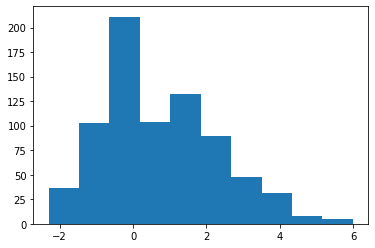

In [30]:
plt.hist(np.log(y))
plt.show()

In [31]:
y = np.log(y)

In [52]:
normal_reg = """
"""

stan_file = "./normal.stan"

with open(stan_file, "w") as f:
    print(normal_reg, file=f)

normal_reg = CmdStanModel(stan_file=stan_file)

INFO:cmdstanpy:compiling stan program, exe file: /Users/marioberaha/didattica/2021_bayes/ese/interactive2/normal
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/marioberaha/didattica/2021_bayes/ese/interactive2/normal


In [53]:
reg_data = {
    "n": len(y),
    "p": X.shape[1],
    "y": y,
    "X": X        
}

fit = normal_reg.sample(reg_data)
normal_az = az.from_cmdstanpy(fit)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2


array([[<AxesSubplot:title={'center':'tau'}>,
        <AxesSubplot:title={'center':'tau'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

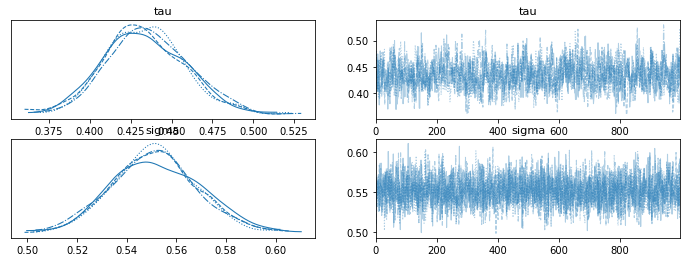

In [54]:
az.plot_trace(normal_az, var_names=["tau", "sigma"])
plt.show()

In [58]:
laplace_reg = """
"""

stan_file = "./laplace.stan"

with open(stan_file, "w") as f:
    print(laplace_reg, file=f)

laplace_reg = CmdStanModel(stan_file=stan_file)

INFO:cmdstanpy:compiling stan program, exe file: /Users/marioberaha/didattica/2021_bayes/ese/interactive2/laplace
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/marioberaha/didattica/2021_bayes/ese/interactive2/laplace


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2


array([[<AxesSubplot:title={'center':'tau'}>,
        <AxesSubplot:title={'center':'tau'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

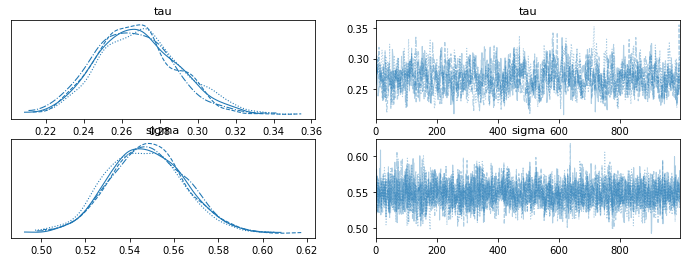

In [59]:
fit = laplace_reg.sample(reg_data)
laplace_az = az.from_cmdstanpy(fit)
az.plot_trace(laplace_az, var_names=["tau", "sigma"])
plt.show()

In [65]:
spike_slab_code = """
"""

stan_file = "./spike_slab.stan"

with open(stan_file, "w") as f:
    print(spike_slab_code, file=f)

spike_slab = CmdStanModel(stan_file=stan_file)

INFO:cmdstanpy:compiling stan program, exe file: /Users/marioberaha/didattica/2021_bayes/ese/interactive2/spike_slab
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/marioberaha/didattica/2021_bayes/ese/interactive2/spike_slab


In [66]:
fit = spike_slab.sample(reg_data)
ss_az = az.from_cmdstanpy(fit)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2


KeyError: 'var names: "[\'tau\'] are not present" in dataset'

array([[<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

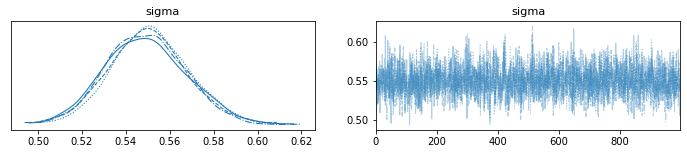

In [67]:
az.plot_trace(ss_az, var_names=["sigma"])
plt.show()

In [71]:
spike_slab_lasso_code = """
"""

stan_file = "./spike_slab_lasso.stan"

with open(stan_file, "w") as f:
    print(spike_slab_lasso_code, file=f)

spike_slab_lasso = CmdStanModel(stan_file=stan_file)

INFO:cmdstanpy:compiling stan program, exe file: /Users/marioberaha/didattica/2021_bayes/ese/interactive2/spike_slab_lasso
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/marioberaha/didattica/2021_bayes/ese/interactive2/spike_slab_lasso


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4


array([[<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

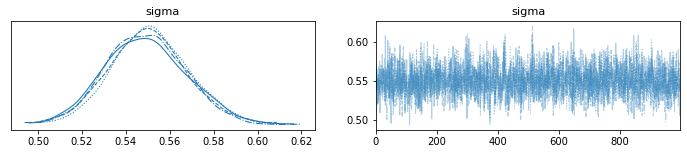

In [72]:
fit = spike_slab_lasso.sample(reg_data)
ssl_az = az.from_cmdstanpy(fit)
az.plot_trace(ss_az, var_names=["sigma"])
plt.show()

In [95]:
reg_hors_code = """
"""

stan_file = "./reg_hors.stan"

with open(stan_file, "w") as f:
    print(reg_hors_code, file=f)

horseshoe = CmdStanModel(stan_file=stan_file)

INFO:cmdstanpy:compiling stan program, exe file: /Users/marioberaha/didattica/2021_bayes/ese/interactive2/reg_hors
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/marioberaha/didattica/2021_bayes/ese/interactive2/reg_hors


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2


array([[<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

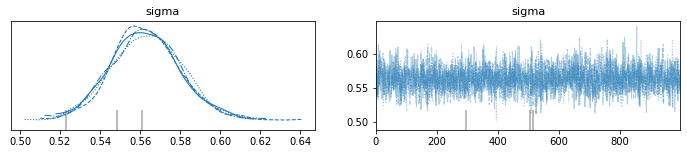

In [96]:
fit = horseshoe.sample(reg_data)
horse_az = az.from_cmdstanpy(fit)
az.plot_trace(horse_az, var_names=["sigma"])
plt.show()

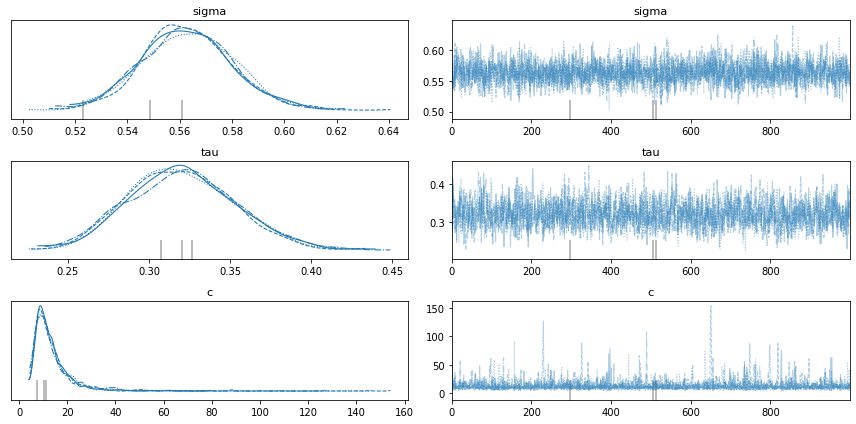

In [97]:
az.plot_trace(horse_az, var_names=["sigma", "tau", "c"])
plt.tight_layout()
plt.show()

In [98]:
az.compare({"normal": normal_az,
            "laplace": laplace_az,
            "ss": ss_az,
            "ssl": ssl_az,
            "reg_hors": horse_az,
           }, var_name="log_lik")

/opt/homebrew/lib/python3.9/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/arviz/stats/stats.py:694: UserWarning: Est

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
laplace,0,-734.610125,169.848529,0.000000,8.245262e-01,23.565183,0.000000,True,log
reg_hors,1,-748.760902,158.919770,14.150778,1.386238e-01,23.077090,6.642365,True,log
normal,2,-753.330311,186.209353,18.720186,5.654066e-13,22.937226,4.497916,True,log
ssl,3,-825.473945,280.360059,90.863820,3.684997e-02,21.365628,13.265354,True,log
ss,4,-844.530517,295.299769,109.920392,0.000000e+00,21.415412,14.299690,True,log


# Exercise 3: Variable Selection

# Exercise 4: take me to the hierarchy-land

In [ ]:
spike_slab_hier_code = """
"""

stan_file = "./spike_slab_hier.stan"

with open(stan_file, "w") as f:
    print(spike_slab_hier_code, file=f)

spike_slab_hier = CmdStanModel(stan_file=stan_file)

In [ ]:
import arviz as az
import matplotlib.pyplot as plt

In [ ]:
reg_data = {
    "n": len(y),
    "p": X.shape[1],
    "k": y.shape[1],
    "y": y,
    "X": X        
}

spike_slab_fit = spike_slab_hier.sample(data=reg_data, chains=4, parallel_chains=4, 
                iter_warmup=1000, iter_sampling=1000, adapt_delta=0.9)

spike_slab_fit_data = az.from_cmdstanpy(spike_slab_fit)

In [ ]:
az.plot_trace(spike_slab_fit_data, var_names="beta", compact=True)
plt.tight_layout()
plt.show()

In [ ]:
az.plot_forest(spike_slab_fit_data, var_names="beta")

In [ ]:
az.plot_trace(spike_slab_fit_data, var_names="p0s", compact=False)
plt.tight_layout()
plt.show()

### Hierarchical Regularised Horseshoe